In [13]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import os
import pprint
from collections import Counter
import joblib
from pprint import pprint
import cv2

# skimage libraries
from skimage.io import imread
from skimage.transform import resize
#from skimage.feature import hog
from skimage.transform import rescale

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt

In [14]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})mini dog images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(f"Reading images for {subdir} ...")
            current_path = os.path.join(src, subdir)
        
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (32, 32)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [15]:
# parameters
IMAGE_PATH = '/Users/jay55/Desktop/deeplearning/data set'
CLASSES = os.listdir(IMAGE_PATH)
BASE_NAME = 'fruit'
WIDTH = 90
 
# load & resize the images
resize_all(src=IMAGE_PATH, pklname=BASE_NAME, width=WIDTH, include=CLASSES)

Reading images for normal ...
Reading images for rotten ...


KeyboardInterrupt: 

In [ ]:
# read from the pickle/dictionary
data = joblib.load(f'{BASE_NAME}_{WIDTH}x{WIDTH}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])


number of samples:  1600
keys:  ['description', 'label', 'filename', 'data']
description:  resized (90x90)mini dog images in rgb
image shape:  (90, 90, 3)
labels: ['normal' 'rotten']


Counter({'normal': 800, 'rotten': 800})

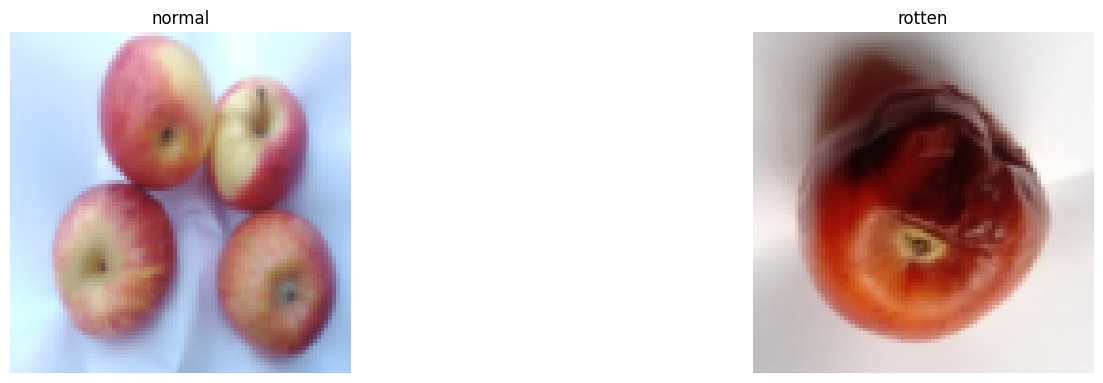

In [ ]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)


In [ ]:
# feature engineering
x = np.array(data['data'])
y = np.array(data['label'])

# split - train & validation
SIZE = 0.1 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state= np.random.randint(1,50),)

# view
print(f"Training Size: {x_train.shape[0]}\n Validation Size: {x_test.shape[0]}")

Training Size: 1440
 Validation Size: 160


In [ ]:
# normalisation
x_train = x_train/255.0
x_test = x_test/255.0

# reshape the array (4d to 2d)
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = x_test.shape
x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))

In [ ]:
# random forest classifier - baseline
rfc = RandomForestClassifier()

# fit
rfc.fit(x_train2,y_train)

# predict
y_pred = rfc.predict(x_test2)

# accuracy score
acc = '{:.1%}'.format(accuracy_score(y_test, y_pred))
print(f"Accuracy for Random Forrest: {acc}")

Accuracy for Random Forrest: 89.4%


In [ ]:
# random forest classifier - hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

# Number of features to consider at every split
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# class weight
class_weight = ['balanced', 'balanced_subsample', None]


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}
             

pprint(param_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', 'balanced_subsample', None],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 60, 110, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 600, 1000]}


In [ ]:
# baseline random forest classifier (for hyperparameter tuning)
rfc_t = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc_t
                               ,param_distributions = param_grid
                               ,n_iter = 10
                               ,cv = 3
                               ,verbose=0
                               ,random_state=42
                               ,n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train2,y_train)

# get the best params
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 60,
 'criterion': 'entropy',
 'class_weight': None,
 'bootstrap': False}

In [ ]:
# random forest classifier - tuned
rfc_t = rf_random.best_estimator_

# fit
history = rfc_t.fit(x_train2,y_train)

# predict
y_pred = rfc_t.predict(x_test2)

# accuracy score
acc = '{:.1%}'.format(accuracy_score(y_test, y_pred))
print(f"Accuracy for Random Forrest (tuned): {acc}")

Accuracy for Random Forrest (tuned): 90.6%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris  # Replace with your dataset

# Example: Load a dataset (replace this with your own data and preprocessing)
data = load_iris()
X, y = data.data, data.target

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X,
    y=y,
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Metric to evaluate
    train_sizes=np.linspace(0.1, 1.0, 10),  # Proportion of training data to use
    n_jobs=-1  # Use all processors for parallel processing
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='green')

# Customize plot
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
